In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import time as time
import copy as copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment
from scipy.stats import spearmanr

In [2]:
XL_PATH = r"radiomicsFeatures.csv"

In [3]:
feats_df = pd.read_csv(XL_PATH)

feats_df.head()

,id,label,sub_wout_original_glcm_ClusterProminence,adc_original_firstorder_Minimum,sub_wout_original_glszm_LowGrayLevelZoneEmphasis,sub_wout_original_firstorder_Maximum,adc_original_glcm_ClusterShade,sub_wout_original_firstorder_Mean,sub_win_original_glcm_Autocorrelation,adc_original_glszm_LargeAreaLowGrayLevelEmphasis,...,sub_win_original_glszm_ZoneEntropy,t2w_original_glszm_SizeZoneNonUniformityNormalized,t2w_original_glcm_JointEntropy,t2w_original_glszm_LargeAreaHighGrayLevelEmphasis,sub_win_original_glszm_SizeZoneNonUniformityNormalized,sub_wout_original_glszm_SmallAreaHighGrayLevelEmphasis,sub_win_original_glcm_MaximumProbability,sub_win_original_glcm_Imc1,sub_wout_original_glcm_JointEntropy,t2w_original_glszm_LargeAreaLowGrayLevelEmphasis
0,2535039,1,4.677862e+06,0.0,0.003103,600.0,14835.837461,299.900214,3755.933491,0.010393,...,6.339939,0.286470,10.166389,27423.571919,0.461100,2946.837800,0.034622,-0.041978,10.452108,0.033786
1,2417361,0,4.834267e+06,0.0,0.001672,600.0,-17634.034850,299.918235,3941.494865,0.058145,...,7.424770,0.350004,11.649157,21732.551407,0.604518,3322.225544,0.002107,-0.109242,11.891117,0.009861
2,2602563,1,5.159220e+06,0.0,0.001600,600.0,-19736.430500,299.820687,2455.254084,0.019202,...,7.239270,0.350692,10.919838,15567.069802,0.574356,3407.597573,0.004002,-0.194449,11.214368,0.018991
3,2902440,0,3.613791e+06,0.0,0.002428,600.0,-12881.976888,299.240444,3954.079034,0.576021,...,7.454390,0.380537,11.530000,18389.243521,0.566131,3121.573712,0.004134,-0.116415,11.669841,0.007846
4,2921898,0,5.773968e+06,0.0,0.001720,600.0,2116.811733,299.983523,3793.819336,0.011764,...,6.755170,0.265413,9.504938,245786.779116,0.469149,3175.569089,0.027634,-0.058680,11.459667,0.024444


In [4]:
feats_df.shape

(100, 91)

### Autoencoder Utilities

##### Dataset

In [5]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, X):
        self.X = X
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.X[i]

In [6]:
class MixupDataset(torch.utils.data.Dataset):
    
    def __init__(self, X):
        self.X = X
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):

        i, j = np.random.randint(len(self.X), size=2)
        
        p = np.random.uniform()
        
        x = p * self.X[i] + (1-p) * self.X[j]
        
        return x, x

##### Architecture

In [7]:
class FC_Block(nn.Module):
    
    def __init__(self, in_feats, hidden_layers, activation_fn = nn.LeakyReLU()):
        
        super(FC_Block, self).__init__()
        
        layers = []
        
        for out_feats in hidden_layers:
            layers += [nn.Linear(in_feats, out_feats), activation_fn]
            in_feats = out_feats
            
        self.block = nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.block(x)
        
        return x
        

In [8]:
class Autoencoder(nn.Module):
    
    def __init__(self, input_dim, encoder_layers=[100,50,25], latent_dim=5, activation_fn = nn.LeakyReLU()):
        
        super(Autoencoder, self).__init__()
        
        self.encoder_block = FC_Block(input_dim, encoder_layers, activation_fn)
        
        self.embedding_layer = nn.Sequential(*[nn.Linear(encoder_layers[-1], latent_dim), activation_fn])
        
        decoder_layers = list(reversed(encoder_layers))
        self.decoder_block = FC_Block(latent_dim, decoder_layers, activation_fn)
        self.scores = nn.Linear(decoder_layers[-1], input_dim)
    
    def forward(self, x):
        
        x = self.encoder_block(x)
        h = x = self.embedding_layer(x)
        x = self.decoder_block(x)
        x = self.scores(x)
        
        return x, h
            

##### Training/Validation

In [9]:
class Model:
    
    def __init__(self, net):
        self.net = net
        
    def compile(self, lr, h_lambda, loss_fn, cuda_device_id=0):
        
        self.h_lambda = h_lambda
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr)
        self.loss_fn = loss_fn 
        self.device = torch.device(f"cuda:{cuda_device_id}" if torch.cuda.is_available() else "cpu")
        
        self.net.to(self.device)
        
    def prepare_minibatch(self, mini_batch):
        
        inputs, targets = mini_batch
        
        return inputs.float().to(self.device), targets.float().to(self.device)
        
    def fit(self, dls, num_epochs, verbose=True):
        
        since = time.time()
        
        hist = {'train':{'loss':[]}, 'val':{'loss':[]}}
        
        best_loss = np.inf
        
        for epoch in range(num_epochs):
            
            if verbose:
                
                print('Epoch {}/{}'.format(epoch,num_epochs-1))
                print('-'*10)
                
            for phase in ["train", "val"]:
                
                if phase=="train":
                    self.net.train()
                else:
                    self.net.eval()
                    
                running_loss = 0.0
                
                for mini_batch in dls[phase]:
                    
                    self.optimizer.zero_grad()
                    
                    inputs, targets = self.prepare_minibatch(mini_batch)
                    
                    with torch.set_grad_enabled(phase=="train"):
                        
                        recon_inputs, h = self.net(inputs)
                        
                        loss = self.loss_fn(recon_inputs, targets) + self.h_lambda * h.flatten().abs().sum()
                        
                        if phase=="train":
                            
                            loss.backward()
                            self.optimizer.step()
                            
                        running_loss += loss.item()
                            
                epoch_loss = running_loss/len(dls[phase])
                hist[phase]["loss"].append(epoch_loss)
                
                if verbose:
                    print("{} Loss :{:.4f}".format(phase,epoch_loss))
                    
                if phase == "val":
                    
                    if epoch_loss<best_loss:
                        best_loss = epoch_loss
                        best_model_wts = copy.deepcopy(self.net.state_dict())
                        if verbose:
                            print(f"Checkpoing made at {epoch}")
                        
            if verbose:
                print()
                
            
        time_elapsed = time.time() - since
        
        
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Loss: {:4f}'.format(best_loss)) 

        
        self.net.load_state_dict(best_model_wts)
        
        return self.net.cpu()

In [10]:
def norm_anomaly_split(X, y):
    
    normal_indeces = np.argwhere(y==0).ravel()
    anomaly_indeces = np.argwhere(y==1).ravel()
    
    X_norm = X[normal_indeces]
    X_anomaly = X[anomaly_indeces]

    return X_norm, X_anomaly
    

In [11]:
def visualize_using_tsne(X, y, n_components=2):
    
    X_transformed = TSNE(n_components = n_components, random_state=0).fit_transform(X)
    
    plt.scatter(*zip(*X_transformed[y==1]), marker='o', color='r', s=10, label='Anomalous')
    plt.scatter(*zip(*X_transformed[y==0]), marker='o', color='g', s=10, label='Normal')
    plt.legend()
    plt.show()
    
    
    

### Sanity Check - Autoencoder Implementation

In [12]:
# https://github.com/mvaldenegro/UncertaintyML-course-ESSAI-labs
# https://github.com/mvaldenegro/UncertaintyML-course-ESSAI-labs/blob/main/02_eval_uncertainty_calibration.ipynb
# https://atcold.github.io/NYU-DLSP20/en/week01/01-3/

In [13]:
feats = [column for column in feats_df.columns if column not in ["id","label"]]
print(len(feats))

89


In [14]:
scaler = StandardScaler()
X = feats_df[feats].to_numpy()
y = feats_df["label"].to_numpy()

# X = scaler.fit_transform(X)

X_norm, X_anomaly = norm_anomaly_split(X, y)

X_norm = scaler.fit_transform(X_norm) #this works better than the alternative where you standardize the whole X
X_anomaly = scaler.transform(X_anomaly)

X_norm = torch.from_numpy(X_norm).float()
X_anomaly = torch.from_numpy(X_anomaly).float()

_, input_dim = X.shape

torch.manual_seed(0)
idx = torch.randperm(len(X_norm))

X_train = X_norm[idx[:-len(X_anomaly)]]

X_test_norm = X_norm[idx[-len(X_anomaly):]]
X_test_anomaly = X_anomaly

# X_test = torch.concat([X_test_norm, X_test_anomaly])


In [15]:
# visualize_using_tsne(X,y)

In [16]:
num_epochs = 10_000
batch_size = 32
loss_fn = nn.MSELoss()

lr = 1e-3

latent_dim = 5

activation_fn = nn.LeakyReLU()

##### 1. Single Standard Autoencoder

In [17]:
train_ds = Dataset(X_train)
val_ds = Dataset(X_train)
dls = {"train":torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True),"val":torch.utils.data.DataLoader(val_ds, batch_size=batch_size)}

h_lambda = 0.0 #disabling l1 sparsity constraint
encoder_layers = [50, 25, 10] #under-complete hidden layers
standard_ae = Autoencoder(input_dim, encoder_layers=encoder_layers, latent_dim=latent_dim, activation_fn = activation_fn)

model = Model(standard_ae)
model.compile(lr, h_lambda, loss_fn)
_ = model.fit(dls, num_epochs, verbose=True)

Epoch 0/9999
----------
train Loss :1.1827
val Loss :1.1731
Checkpoing made at 0

Epoch 1/9999
----------
train Loss :1.2047
val Loss :1.1721
Checkpoing made at 1

Epoch 2/9999
----------
train Loss :1.1111
val Loss :1.1711
Checkpoing made at 2

Epoch 3/9999
----------
train Loss :1.0317
val Loss :1.1702
Checkpoing made at 3

Epoch 4/9999
----------
train Loss :1.0413
val Loss :1.1694
Checkpoing made at 4

Epoch 5/9999
----------
train Loss :1.0353
val Loss :1.1686
Checkpoing made at 5

Epoch 6/9999
----------
train Loss :0.9682
val Loss :1.1677
Checkpoing made at 6

Epoch 7/9999
----------
train Loss :1.2820
val Loss :1.1669
Checkpoing made at 7

Epoch 8/9999
----------
train Loss :1.1930
val Loss :1.1660
Checkpoing made at 8

Epoch 9/9999
----------
train Loss :1.0479
val Loss :1.1652
Checkpoing made at 9

Epoch 10/9999
----------
train Loss :0.9861
val Loss :1.1642
Checkpoing made at 10

Epoch 11/9999
----------
train Loss :1.0405
val Loss :1.1633
Checkpoing made at 11

Epoch 12/999

In [20]:
recon_X_test_norm, h = model.net(X_test_norm)
recon_X_test_anomaly, h = model.net(X_test_anomaly)

normal_mse = nn.MSELoss(reduction="none")(recon_X_test_norm, X_test_norm).mean(axis=0).detach().numpy()
anomaly_mse = nn.MSELoss(reduction="none")(recon_X_test_anomaly, X_test_anomaly).mean(axis=0).detach().numpy()

delta = anomaly_mse - normal_mse
rank = len(delta) - (delta.argsort().argsort() + 1) + 1

print(normal_mse.mean(), anomaly_mse.mean())


1.352364 1.589208


(array([18., 13., 25.,  9., 10.,  7.,  4.,  2.,  0.,  1.]),
 array([0.11196597, 0.62425148, 1.13653696, 1.64882243, 2.16110802,
        2.67339349, 3.18567896, 3.69796443, 4.2102499 , 4.72253513,
        5.23482084]),
 <BarContainer object of 10 artists>)

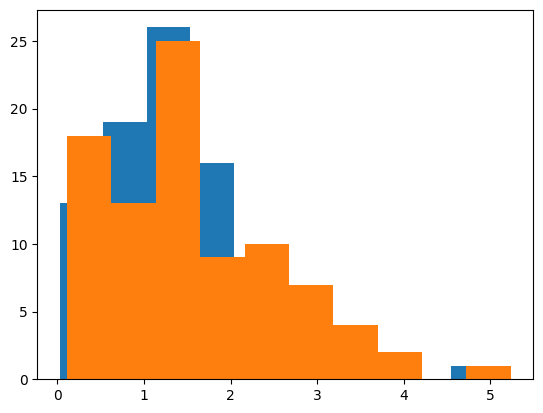

In [21]:
plt.hist(normal_mse)
plt.hist(anomaly_mse)

##### 2. Single Sparse Autoencoder

In [22]:
train_ds = Dataset(X_train)
val_ds = Dataset(X_train)
dls = {"train":torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True),"val":torch.utils.data.DataLoader(val_ds, batch_size=batch_size)}

h_lambda = 1e-2 #with l1 regularization
encoder_layers = [50, 25, 10] #under-complete hidden layers
sparse_ae = Autoencoder(input_dim, encoder_layers=encoder_layers, latent_dim=latent_dim, activation_fn = activation_fn)

model = Model(sparse_ae)
model.compile(lr, h_lambda, loss_fn)
_ = model.fit(dls, num_epochs, verbose=True)

Epoch 0/9999
----------
train Loss :1.3664
val Loss :1.1747
Checkpoing made at 0

Epoch 1/9999
----------
train Loss :1.1172
val Loss :1.1737
Checkpoing made at 1

Epoch 2/9999
----------
train Loss :1.1652
val Loss :1.1727
Checkpoing made at 2

Epoch 3/9999
----------
train Loss :1.0039
val Loss :1.1720
Checkpoing made at 3

Epoch 4/9999
----------
train Loss :0.9595
val Loss :1.1713
Checkpoing made at 4

Epoch 5/9999
----------
train Loss :1.1196
val Loss :1.1706
Checkpoing made at 5

Epoch 6/9999
----------
train Loss :1.0663
val Loss :1.1700
Checkpoing made at 6

Epoch 7/9999
----------
train Loss :1.2606
val Loss :1.1694
Checkpoing made at 7

Epoch 8/9999
----------
train Loss :1.1159
val Loss :1.1687
Checkpoing made at 8

Epoch 9/9999
----------
train Loss :0.9553
val Loss :1.1681
Checkpoing made at 9

Epoch 10/9999
----------
train Loss :0.9864
val Loss :1.1675
Checkpoing made at 10

Epoch 11/9999
----------
train Loss :0.9408
val Loss :1.1669
Checkpoing made at 11

Epoch 12/999

In [23]:
recon_X_test_norm, h = model.net(X_test_norm)
recon_X_test_anomaly, h = model.net(X_test_anomaly)

normal_mse = nn.MSELoss(reduction="none")(recon_X_test_norm, X_test_norm).mean(axis=0).detach().numpy()
anomaly_mse = nn.MSELoss(reduction="none")(recon_X_test_anomaly, X_test_anomaly).mean(axis=0).detach().numpy()

delta = anomaly_mse - normal_mse
rank = len(delta) - (delta.argsort().argsort() + 1) + 1

print(normal_mse.mean(), anomaly_mse.mean())


0.8666589 1.0349263


(array([16., 28., 24.,  7.,  3.,  6.,  1.,  0.,  2.,  2.]),
 array([0.04345095, 0.44564691, 0.84784287, 1.25003886, 1.65223479,
        2.05443072, 2.45662665, 2.85882282, 3.26101875, 3.66321468,
        4.06541061]),
 <BarContainer object of 10 artists>)

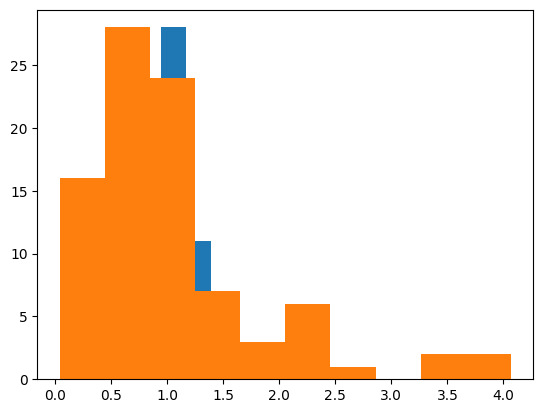

In [24]:
plt.hist(normal_mse)
plt.hist(anomaly_mse)

### Sanity Check - Stability Metrics

In [ ]:
## Jaccard Score

In [167]:
max(1,2)

2

In [341]:
#un-ordered similarity metric

def jaccard_index(df1, df2, k):

    N = len(df1) # or len(df2)

    assert set(["feature", "rank"]).issubset(df1.columns) and set(["feature", "rank"]).issubset(df2.columns), "missing columns - feature, rank"
    assert k<=N, f"k should be <={N}"

    f1 = df1.sort_values(by="rank")["feature"].to_list()
    f2 = df2.sort_values(by="rank")["feature"].to_list()

    f1_k, f2_k = set(f1[:k]), set(f2[:k])

    return len(f1_k & f2_k)/len(f1_k | f2_k)

def dice_index(df1, df2, k):

    N = len(df1) # or len(df2)

    assert set(["feature", "rank"]).issubset(df1.columns) and set(["feature", "rank"]).issubset(df2.columns), "missing columns - feature, rank"
    assert k<=N, f"k should be <={N}"

    f1 = df1.sort_values(by="rank")["feature"].to_list()
    f2 = df2.sort_values(by="rank")["feature"].to_list()
    
    f1_k, f2_k = set(f1[:k]), set(f2[:k])

    return (2 * len(f1_k & f2_k))/(len(f1_k)+len(f2_k))

def kuncheva_index(df1, df2, k):

    # for kuncheva index boundaries to work you have to make sure that features in df1 and df2 are the same

    N = len(df1) # or len(df2)

    assert set(["feature", "rank"]).issubset(df1.columns) and set(["feature", "rank"]).issubset(df2.columns), "missing columns - feature, rank"
    assert k<=N, f"k should be <={N}"
    
    if k==0 or k==N: #not defined
        return 0.0

    f1 = df1.sort_values(by="rank")["feature"].to_list()
    f2 = df2.sort_values(by="rank")["feature"].to_list()

    f1_k, f2_k = set(f1[:k]), set(f2[:k])

    r = len(f1_k & f2_k)

    return (r*N - (k**2))/(k * (N-k))

def mwm_index(df1, df2, feats_df, k):

    assert set(["feature", "rank"]).issubset(df1.columns) and set(["feature", "rank"]).issubset(df2.columns), "missing columns - feature, rank"

    f1 = df1.sort_values(by="rank")["feature"].to_list()
    f2 = df2.sort_values(by="rank")["feature"].to_list()

    f1_k, f2_k = f1[:k], f2[:k]

    f = list(set(f1_k) | set(f2_k))
    corr_matrix = feats_df[f].corr(method='spearman').abs()
    cost_matrix = corr_matrix.loc[f1_k, f2_k]
    
    row_ind, col_ind = linear_sum_assignment(cost_matrix, maximize=True)

    return cost_matrix.values[row_ind, col_ind].sum()/k

    
# ordered similarity metric

def spearman_rank_index(df1, df2):

    assert set(["feature", "rank"]).issubset(df1.columns) and set(["feature", "rank"]).issubset(df2.columns), "missing columns - feature, rank"

    r1 = df1.sort_values(by="feature")["rank"].to_numpy()
    r2 = df2.sort_values(by="feature")["rank"].to_numpy()

    N = len(r1) # or len(r2)
    
    return 1 - ((6*(r1-r2)**2).sum()/(N*(N**2 - 1)))

 # def stability(similarity_fn, r1_list, r2_list):

    

    
    

In [312]:
df1 = pd.DataFrame({"feature":feats[:10], "rank":range(10)})
df2 = pd.DataFrame({"feature":feats[:10], "rank":range(9,-1,-1)})

In [323]:
[(i,jaccard_index(df1, df2,i)) for i in range(1,11)]

[(1, 0.0),
 (2, 0.0),
 (3, 0.0),
 (4, 0.0),
 (5, 0.0),
 (6, 0.2),
 (7, 0.4),
 (8, 0.6),
 (9, 0.8),
 (10, 1.0)]

In [324]:
[(i,dice_index(df1, df2,i)) for i in range(1,11)]

[(1, 0.0),
 (2, 0.0),
 (3, 0.0),
 (4, 0.0),
 (5, 0.0),
 (6, 0.3333333333333333),
 (7, 0.5714285714285714),
 (8, 0.75),
 (9, 0.8888888888888888),
 (10, 1.0)]

In [325]:
[(i,kuncheva_index(df1, df2,i)) for i in range(1,11)]

[(1, -0.1111111111111111),
 (2, -0.25),
 (3, -0.42857142857142855),
 (4, -0.6666666666666666),
 (5, -1.0),
 (6, -0.6666666666666666),
 (7, -0.42857142857142855),
 (8, -0.25),
 (9, -0.1111111111111111),
 (10, 0.0)]

In [326]:
[(i,mwm_index(df1, df2, feats_df, i)) for i in range(1,11)]

[(1, 0.04206420642064206),
 (2, 0.12452619642200803),
 (3, 0.23923300359399655),
 (4, 0.22518252997370383),
 (5, 0.2709591052870938),
 (6, 0.4834550199824692),
 (7, 0.6739570015402843),
 (8, 0.781131549105502),
 (9, 0.8935626896022936),
 (10, 1.0)]

In [346]:
spearman_rank_index(df2, df2)

1.0

##### 3. Ensemble Sparse Autoencoders 

In [ ]:
ensemble_count = 100

num_epochs = 10_000
batch_size = 32
loss_fn = nn.MSELoss()

lr = 1e-3

latent_dim = 5

activation_fn = nn.LeakyReLU()

h_lambda = 1e-2 #with l1 regularization
encoder_layers = [50, 25, 10] #under-complete hidden layers
sparse_ae = Autoencoder(input_dim, encoder_layers=encoder_layers, latent_dim=latent_dim, activation_fn = activation_fn)

results_df = {**{"ae_id":[], "mse_mean":[]}, **{"mse_"+f:[] for f in feats}, **{"label":[]}}

In [ ]:
for ae_id in range(ensemble_count):
    
    print("*"*50)
    print(f"Autoencoder ID: {ae_id+1}")

    scaler = StandardScaler()
    X = feats_df[feats].to_numpy()
    y = feats_df["label"].to_numpy()

    # X = scaler.fit_transform(X)

    X_norm, X_anomaly = norm_anomaly_split(X, y)

    X_norm = scaler.fit_transform(X_norm) #this works better than the alternative where you standardize the whole X
    X_anomaly = scaler.transform(X_anomaly)

    X_norm = torch.from_numpy(X_norm).float()
    X_anomaly = torch.from_numpy(X_anomaly).float()

    _, input_dim = X.shape

    # torch.manual_seed(0) #this is where each ensemble run essentially differ, 
    idx = torch.randperm(len(X_norm))

    X_train = X_norm[idx[:-len(X_anomaly)]]

    X_test_norm = X_norm[idx[-len(X_anomaly):]]
    X_test_anomaly = X_anomaly

    
    train_ds = Dataset(X_train)
    val_ds = Dataset(X_train)
    dls = {"train":torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True),"val":torch.utils.data.DataLoader(val_ds, batch_size=batch_size)}

    model = Model(sparse_ae)
    model.compile(lr, h_lambda, loss_fn)
    _ = model.fit(dls, num_epochs, verbose=False)
    
    recon_X_test_norm, h = model.net(X_test_norm)
    recon_X_test_anomaly, h = model.net(X_test_anomaly)

    normal_mse = nn.MSELoss(reduction="none")(recon_X_test_norm, X_test_norm).mean(axis=0).detach().numpy()
    anomaly_mse = nn.MSELoss(reduction="none")(recon_X_test_anomaly, X_test_anomaly).mean(axis=0).detach().numpy()
    
    
    results_df["ae_id"].append(ae_id+1)
    results_df["mse_mean"].append(normal_mse.mean())
    for f, f_normal_mse in zip(feats, normal_mse):
        results_df["mse_"+f].append(f_normal_mse)
    results_df["label"].append(0)
        
    results_df["ae_id"].append(ae_id+1)
    results_df["mse_mean"].append(anomaly_mse.mean())
    for f, f_anomaly_mse in zip(feats, anomaly_mse):
        results_df["mse_"+f].append(f_anomaly_mse)
    results_df["label"].append(1)
        
    print("normal_mse=", normal_mse.mean(), "anomaly_mse=", anomaly_mse.mean())
    
results_df = pd.DataFrame(results_df)

In [ ]:
results_df.to_csv("results_df.csv", index=False)